<a href="https://colab.research.google.com/github/GodRishUniverse/Deepfake-detect-AIC/blob/main/Learning/Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [120]:
import os

# Move kaggle.json to the correct directory
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

# Set permissions to prevent permission errors
!chmod 600 ~/.kaggle/kaggle.json

mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [121]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

In [122]:
!kaggle datasets list -s deepfake

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 4, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.11/dist-packages/kaggle/__init__.py", line 7, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 407, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/


In [123]:
!kaggle datasets download -d manjilkarki/deepfake-and-real-images

Dataset URL: https://www.kaggle.com/datasets/manjilkarki/deepfake-and-real-images
License(s): unknown
deepfake-and-real-images.zip: Skipping, found more recently modified local copy (use --force to force download)


In [124]:
!unzip deepfake-and-real-images.zip -d deepfake-and-real-images.zip

Archive:  deepfake-and-real-images.zip
checkdir:  cannot create extraction directory: deepfake-and-real-images.zip
           File exists


In [125]:
!unzip deepfake-and-real-images.zip -d deepfake-and-real-images.zip

Archive:  deepfake-and-real-images.zip
checkdir:  cannot create extraction directory: deepfake-and-real-images.zip
           File exists


In [126]:
import shutil
import zipfile

# Remove existing folder if it exists
shutil.rmtree("deepfake-and-real-images", ignore_errors=True)

# Extract the ZIP file again
with zipfile.ZipFile("deepfake-and-real-images.zip", "r") as zip_ref:
    zip_ref.extractall("deepfake-and-real-images")

# Confirm extraction
import os
print(os.listdir("deepfake-and-real-images"))

['Dataset']


In [127]:
from pathlib import Path

In [128]:
data_path = Path('deepfake-and-real-images')
image_path = data_path / "Dataset"
train_path = image_path / "Train"
test_path = image_path / "Test"

In [129]:
import random
from PIL import Image
#set seed
#random.seed(42)

#Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

#pick a random image path
random_image_path = random.choice(image_path_list)

In [130]:
image_class = random_image_path.parent.stem

Random Image Path: deepfake-and-real-images/Dataset/Train/Fake/fake_58346.jpg
Image class: Fake
Image Heigh: 256
Image Width: 256


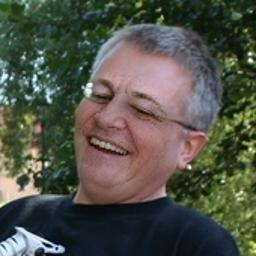

In [131]:
img = Image.open(random_image_path)
#print metadata
print(f'Random Image Path: {random_image_path}')
print(f"Image class: {image_class}")
print(f'Image Heigh: {img.height}')
print(f'Image Width: {img.width}')
img

In [132]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

(-0.5, 255.5, 255.5, -0.5)

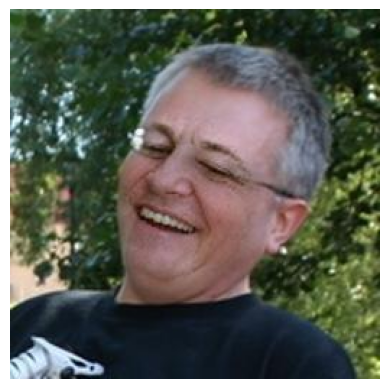

In [133]:
import numpy as np
import matplotlib.pyplot as plt
img_as_array = np.asarray(img)
plt.imshow(img)
plt.axis(False)

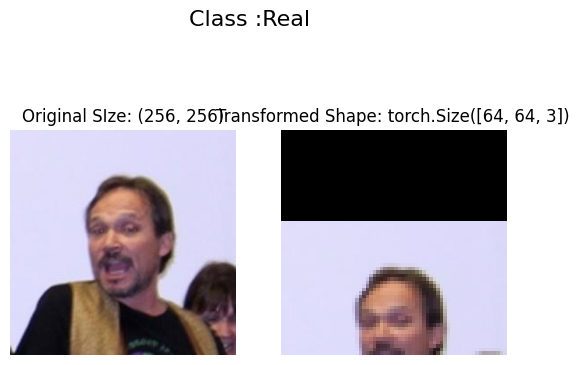

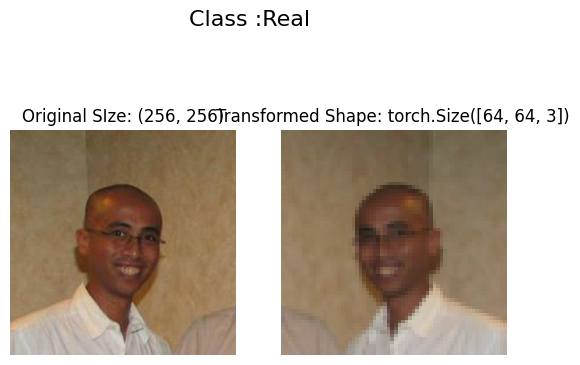

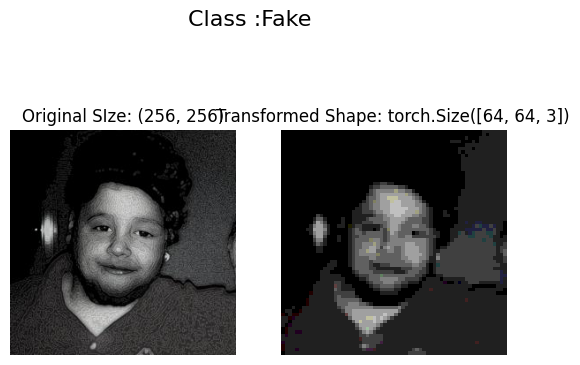

In [134]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
data_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.TrivialAugmentWide(),
    transforms.ColorJitter(),
    transforms.ToTensor()
])
def plot_transformed_images(image_paths, transforms, n=3, seed = 42):
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows = 1, ncols = 2)
      ax[0].imshow(f)
      ax[0].set_title(f'Original SIze: {f.size}')
      ax[0].axis(False)

      transformed_image = transforms(f).permute(1,2,0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f'Transformed Shape: {transformed_image.shape}')
      ax[1].axis(False)
      fig.suptitle(f'Class :{image_path.parent.stem}', fontsize = 16)
plot_transformed_images(image_path_list, data_transforms)

In [135]:
train_data = datasets.ImageFolder(root = train_path,
                                  transform= data_transforms,
                                  target_transform=None)
test_data = datasets.ImageFolder(root = test_path,
                                 transform = data_transforms)
classes = train_data.classes

In [136]:
train_dataloader = DataLoader(dataset=train_data, batch_size = 8, num_workers=1, shuffle = True) # Reduced batch size to 16
test_dataloader = DataLoader(dataset = test_data, batch_size = 8, num_workers=1, shuffle = False) # Reduced batch size to 16

In [150]:
class DeepfakeDetectionModel(nn.Module):
  def __init__(self, in_features, out_features, hidden_units):
    super().__init__()
    #We need multiple blocks for out data to pass through
    self.block1 = nn.Sequential(
        #First the convuloutional layer
        nn.Conv2d(in_channels=in_features,
                  out_channels = hidden_units,
                  kernel_size=3,
                  stride = 1,
                  padding=0),
        nn.BatchNorm2d(hidden_units),  # Add Batch Normalization
        ##ReLU layer
        nn.LeakyReLU(),
        #Maxpool Layer
        nn.MaxPool2d(kernel_size=2,
                     stride = 2))
    #Same block
    self.block2 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride = 1,
                  padding = 0),
        nn.BatchNorm2d(hidden_units),  # Add Batch Normalization
        nn.LeakyReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels = hidden_units,
                  kernel_size=3,
                  stride = 1,
                  padding = 0),
        nn.BatchNorm2d(hidden_units),  # Add Batch Normalization
        nn.LeakyReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride = 2))

    self.dropout = nn.Dropout(0.4)  # Add dropout to prevent overfitting

    self.classifier = nn.Sequential(
        nn.Flatten(),
        # Calculate the correct input features dynamically
        nn.Linear(in_features = hidden_units * 13 * 13, out_features=out_features), #Updated this line to match the output of block2
        nn.LeakyReLU(),
        nn.Dropout(0.5),  # Add another dropout
        nn.Linear(out_features, out_features) #Updated to output_features so the shapes match
    )
  #Forward pass the data through the different layers, and return the final output of x
  def forward(self,x):
      x = self.block1(x)
      x = self.block2(x)
      x = self.dropout(x)
      x = self.classifier(x)
      return x

In [151]:
len(classes)

2

In [152]:
model = DeepfakeDetectionModel(in_features=3, out_features=1, hidden_units=10).to(device)

In [153]:
image_batch, label_batch = next(iter(train_dataloader)) #Create dummy data do find out what the value needs to be for the input shape of our linear layer

In [154]:
image_batch.shape, label_batch.shape

(torch.Size([8, 3, 64, 64]), torch.Size([8]))

In [155]:
model(image_batch.to(device))

tensor([[-0.7229],
        [-0.7199],
        [-0.7199],
        [-0.7199],
        [-0.7224],
        [-0.7212],
        [-0.7199],
        [-0.7222]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [163]:
# Hyperparameters
LEARNING_RATE = 0.0005
BATCH_SIZE = 32
EPOCHS = 10
STEP_SIZE = 10
GAMMA = 0.1
WEIGHT_DECAY = 1e-5

In [168]:
from torch import nn
from torch import optim

loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr = LEARNING_RATE, weight_decay = WEIGHT_DECAY)
# TODO  - change the scheduler accordingly
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = STEP_SIZE, gamma = GAMMA)

In [167]:
def train_one_step(model, dataloader, optimizer, scheduler, loss, device):
  model.train()
  total_loss = 0
  for image_batch, label_batch in dataloader:
    image_batch = image_batch.to(device)
    label_batch = label_batch.to(device)
    pred = model(image_batch)
    loss = loss_fn(pred, label_batch.unsqueeze(1).float())
    total_loss += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()
  return total_loss/len(dataloader)

In [166]:
def test(model, dataloader, loss_fn, device):
  model.eval()
  loss = 0
  #Context manager to disable gradient calculation during testing
  with torch.no_grad(): #This will stop pytorch from storing gradients during evaluation
    for image_batch, label_batch in dataloader:
      image_batch = image_batch.to(device)
      label_batch = label_batch.to(device)
      pred = model(image_batch)
      loss += loss_fn(pred, label_batch.unsqueeze(1).float()).item() #Call .item() to move the loss to the CPU and save memory on the GPU
  return loss/len(dataloader)

In [164]:
%pip install tqdm

In [165]:
from tqdm.auto import tqdm
def train(model, train_dataloader, test_dataloader, optimizer, scheduler, loss_fn, epochs, device):
  for epoch in tqdm(range(epochs)):
    loss = train_one_step(model, train_dataloader, optimizer, scheduler, loss_fn, device)
    test_loss = test(model, test_dataloader, loss_fn, device)
    print(f"Epoch: [{epoch+1}/{epochs}] | Loss: {loss} | Test Loss: {test_loss}")

In [ ]:
# TODO: add other metrics like accuracy, f1_score, etc.
train(model, train_dataloader, test_dataloader, optimizer, scheduler, loss_fn, EPOCHS, device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: [1/10] | Loss: 0.7556314080669215 | Test Loss: 0.753348268065984
Epoch: [2/10] | Loss: 0.7556421470879814 | Test Loss: 0.753390786388228
Epoch: [3/10] | Loss: 0.7556375263656973 | Test Loss: 0.7534163084503842
Epoch: [4/10] | Loss: 0.755628235206884 | Test Loss: 0.7533823061636117
